# Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images
Reproduce Results of [Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images](https://pubmed.ncbi.nlm.nih.gov/30094778/)


> We used a pre-trained CNN to extract features based on B-mode images. Next, using the neural features, we employed the support vector machine (SVM) algorithm to classify images containing fatty liver. Aside of fatty liver classification, it is clinically relevant to quantify the grade of liver steatosis. For this task, we used the extracted features and the Lasso regression method. In both cases, liver biopsy results served as a reference. The performance of the pro- posed approach was compared with the GLCM methods.





In [15]:
import sys
sys.path.append('../src')
import warnings
warnings.filterwarnings("ignore") 

from utils.reduce import reduce_pca
from utils.split import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

from itertools import product
import pickle
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt


In [ ]:
mlflow.set_experiment('scattering_svm_pca_experiment')

## Feature Reduction/Selection

#### Upload Scattering Features

In [34]:
with open('../data/03_features/scattering_features.pickle', 'rb') as handle:
    scatter_dict = pickle.load(handle)
    df_scattering = scatter_dict['df']
    scattering_params = {'J':scatter_dict['J'],
                         'M':scatter_dict['M'],
                         'N':scatter_dict['N']}

#### Apply PCA

Since sklearn is used for PCA, the dataset will be transformed into a panda dataframe.

In [35]:
pca_n_components = 5
df_scattering_10 = reduce_pca(data=df_scattering, n_components=pca_n_components)

# Cross Validation using SVM Classification

> Methods that exclude outliers were used to normalize the features. Patient-specific leave-one-out cross-validation (LOOCV) was applied to evaluate the classification. In each case, the test set consisted of10 images from the same patient and the training set contained 540 images from the remaining 54 patients. For each training set, fivefold cross-validation and grid search were applied to indicate the optimal SVM classifier hyperparameters and the best kernel. To address the problem of class imbalance, the SVM hyperparameter C of each class was adjusted inversely proportional to that class frequency in the training set. Label 1 indicated the image containing a fatty liver and label −1 otherwise. 


In [36]:
df_train, df_test = train_test_split(df_scattering_10)

In [37]:
# Set the parameters by cross-validation
param_gamma = [1e-3, 1e-4]
param_C = [1, 10, 100, 1000]
rbf_params = list(product(['kernel'],param_gamma, param_C))
linear_params = list(product(['linear'],param_C))
params = rbf_params + linear_params

In [38]:
standardize = True

df_train_pid = df_train.pop('id')
df_train_y = df_train.pop('class')
search_metrics = {}

for param in params:
    # Do cross-validation
    with mlflow.start_run():
        mlflow.log_param('pca_n',pca_n_components)
        mlflow.log_params(scattering_params)
        group_kfold = GroupKFold(n_splits=5)
        metrics = []
        for train_index, valid_index in group_kfold.split(df_train, 
                                                          df_train_y, 
                                                          df_train_pid):
            X_train, X_valid = df_train.iloc[train_index], df_train.iloc[valid_index]
            y_train, y_valid = df_train_y.iloc[train_index], df_train_y.iloc[valid_index]

            if standardize:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_valid = scaler.transform(X_valid)
            
            mlflow.log_param('model',f'svm: {param[0]}')
            if param[0] == 'kernel': 
                mlflow.log_param('gamma',param[1])
                mlflow.log_param('C',param[2])
                model = SVC(gamma=param[1], C=param[2])
            if param[0] == 'linear': 
                model = LinearSVC(C=param[1])
                mlflow.log_param('C',param[1])
            model.fit(X_train, y_train)
            predictions = model.predict(X_valid)
            acc = accuracy_score(y_valid, predictions)

            metrics.append(acc)
        
        search_metrics[str(param)] = np.mean(metrics)
        
        mlflow.log_metric('accuracy',np.mean(metrics))
        

# Analyzing PCA




In [25]:
pca = PCA(n_components=50)
data = pca.fit_transform(df_scattering)

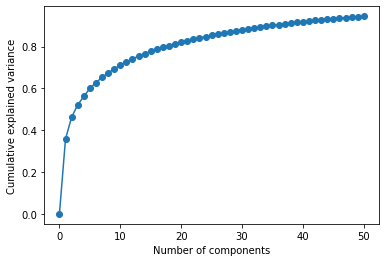

In [26]:
plt.plot(np.insert(pca.explained_variance_ratio_.cumsum(),0,0),marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [27]:
print(pca.explained_variance_ratio_.cumsum())

[0.358229   0.46256775 0.5213122  0.5615727  0.60021013 0.6280708
 0.6526942  0.6741075  0.6933188  0.71118236 0.7272146  0.7416112
 0.75492215 0.76626295 0.77692294 0.7868516  0.7964909  0.8051731
 0.81322485 0.82102334 0.828144   0.8350312  0.8416648  0.8480806
 0.8541647  0.8600241  0.86547524 0.8706865  0.8758702  0.88077354
 0.8853577  0.8898133  0.89404804 0.89821213 0.9021143  0.90581274
 0.90947115 0.91286314 0.916123   0.91932863 0.9223907  0.92539936
 0.92826146 0.9310725  0.9337355  0.93633085 0.9387765  0.9410663
 0.94322944 0.94532514]


# Test Prediction

In [5]:
# !mlflow ui 
# Set a new mlflow experiment
# Use the best hyperparameters to train a model on the whole training data
# Test and record results!
mlflow.set_experiment('test_results_dataset_liver_bmodes_steatosis_assessment_IJCARS')

Best combination of hyper parameters
<img width="782" alt="Screen Shot 2020-09-29 at 8 47 03 PM" src="https://user-images.githubusercontent.com/23482039/94630966-36573680-0295-11eb-9352-18b1796b3fd4.png">

In [12]:
with open('../data/03_features/scattering_features.pickle', 'rb') as handle:
    scatter_dict = pickle.load(handle)
    df_scattering = scatter_dict['df']
    scattering_params = {'J':scatter_dict['J'],
                         'M':scatter_dict['M'],
                         'N':scatter_dict['N']}

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pca_n_components = 10
df_scattering_10 = reduce_pca(data=df_scattering, n_components=pca_n_components)
df_train, df_test = train_test_split(df_scattering_10)
standardize = True


df_train.pop('id')
df_test.pop('id')
df_train_y = df_train.pop('class')
df_test_y = df_test.pop('class')


In [ ]:
pca_n_components = 10
df_scattering_10 = reduce_pca(data=df_scattering, n_components=pca_n_components)
df_train, df_test = train_test_split(df_scattering_10)

In [ ]:
with mlflow.start_run():
    model =  SVC(gamma= 1e-4, C=1000)
    model.fit(df_train, df_train_y)
    predictions = model.predict(df_test)
    acc = accuracy_score(df_test_y, predictions)
    mlflow.log_param('Model', 'Scattering features + PCA + SVM')
    mlflow.log_metric('accuracy', acc)


In [ ]:
print('The test accuracy of the model is ', acc)